In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

os.chdir('..')

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from experiments.data.data import get_data, get_cf_data
from experiments.data.utils import read_borf_res, read_mcels_res, read_glacier_res
from experiments.competitors.glacier.src.help_functions import (
    conditional_pad,
    time_series_normalize,
)

2025-06-04 09:07:32.089293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 09:07:32.209845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749020852.258760   26887 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749020852.272520   26887 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 09:07:32.383904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
borf_org_cf, borf_cf = read_borf_res('experiments/out/cf/borf_0307/TwoLeadECG/assets/out.pkl')
mcels_cf = read_mcels_res('experiments/out/cf/mcels/TwoLeadECG/saliency_cf.npy')
glacier_cf = read_glacier_res('experiments/out/cf/glacier/TwoLeadECG/cf.pkl')

X_train, y_train, X_test, y_test = get_data('TwoLeadECG')
borf_org_cf = np.vstack(borf_org_cf)

# scaler = MinMaxScaler()
# scaler.fit(X_train.reshape(X_train.shape[0], -1))

# glacier_cf = scaler.inverse_transform(glacier_cf.reshape(glacier_cf.shape[0], -1))

X_cf, _ = get_cf_data(X_test, y_test)

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train.reshape(X_train.shape[0], -1))

_, trained_scaler = time_series_normalize(
            data=X_train, n_timesteps=X_train.shape[2]
        )

glacier_cfs, _ = time_series_normalize(
    data=glacier_cf,
    n_timesteps=glacier_cf.shape[-1],
    scaler=trained_scaler,
)

glacier_cfs= scaler.inverse_transform(
    glacier_cfs.reshape(glacier_cfs.shape[0], -1)
)

# glacier_cfs, _ = conditional_pad(glacier_cfs)

In [6]:
from experiments.data.metrics import validity, euclidean_distance

In [7]:
if True:
    mean, std = borf_org_cf.mean(), borf_org_cf.std()
    obs = (borf_cf - mean) / std
    cfs = (borf_cf - mean) / std
obs[np.isnan(obs)] = 0
cfs[np.isnan(cfs)] = 0
# paired_distances = np.linalg.norm(obs - cfs, axis=1)
paired_distances = np.linalg.norm(obs - cfs, axis=1)
# return np.mean(paired_distances)

In [8]:
IDX = -1

Text(0.5, 1.0, 'Glacier')

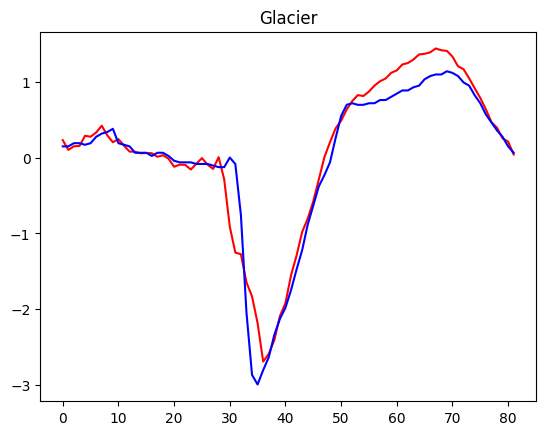

In [9]:
steps = np.arange(X_cf.shape[2])

plt.plot(steps, glacier_cfs[43, :], c='r')
plt.plot(steps, X_cf[43, 0, :], c='b')
plt.title('Glacier')

Text(0.5, 1.0, 'MCELS')

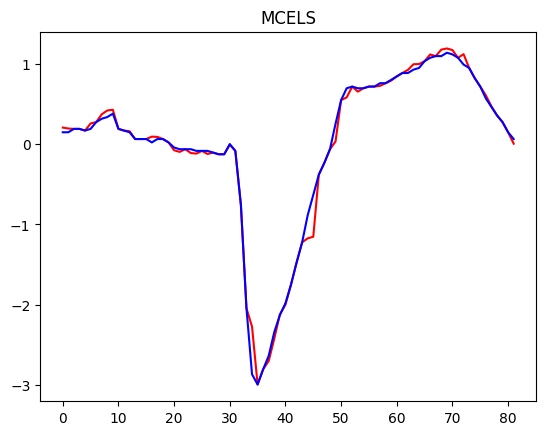

In [10]:
steps = np.arange(X_cf.shape[2])

plt.plot(steps, mcels_cf[43, 0, :], c='r')
plt.plot(steps, X_cf[43, 0, :], c='b')
plt.title('MCELS')

Text(0.5, 1.0, 'BoRF')

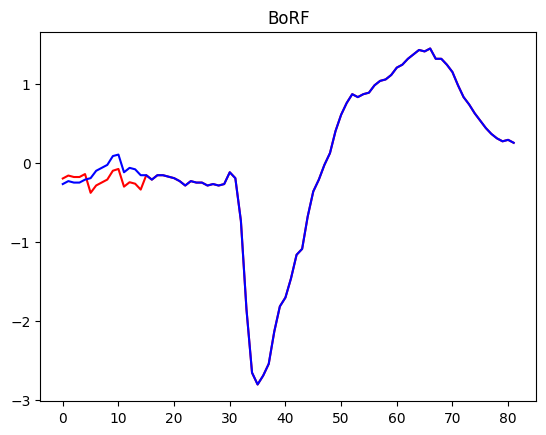

In [11]:
steps = np.arange(X_cf.shape[2])

plt.plot(steps, borf_cf[IDX, 0, :], c='r')
plt.plot(steps, borf_org_cf[IDX, 0, :], c='b')
plt.title('BoRF')

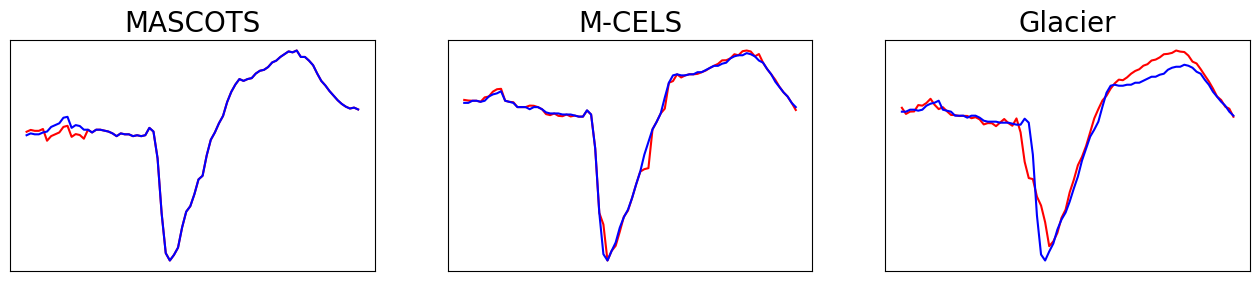

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 3))
axs = axs.flatten()

axs[0].set_title(r'MASCOTS', fontsize=20)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].plot(steps, borf_cf[IDX, 0, :], c='r')
axs[0].plot(steps, borf_org_cf[IDX, 0, :], c='b')

axs[1].set_title(r'M-CELS', fontsize=20)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].plot(steps, mcels_cf[43, 0, :], c='r')
axs[1].plot(steps, X_cf[43, 0, :], c='b')

axs[2].set_title(r'Glacier', fontsize=20)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].plot(steps, glacier_cfs[43, :], c='r')
axs[2].plot(steps, X_cf[43, 0, :], c='b')

plt.savefig('./media/article/results-comp.pdf')